In [1]:
# --- Imports ---
%matplotlib inline

import geopandas as gpd
import math
import matplotlib
import numpy as np
import pandas as pd
import shapely
import sys,os
import pathos.multiprocessing as multiprocessing
from geopandas import GeoDataFrame, GeoSeries
from shapely.geometry import Polygon, Point
from rtree import index



## Load and clean constraint shapefiles

In [2]:
cities = GeoDataFrame.from_file('./geodata/ca_cities/Cities2015.shp')
water = GeoDataFrame.from_file('./geodata/baywater/bayarea_allwater.shp')

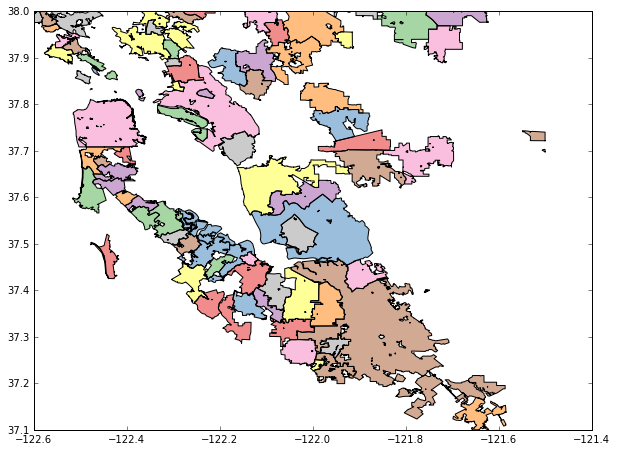

In [3]:

# This is the cropped area - full geojson is all cities in CA
bayarea = Polygon([(-122.6, 37.1), (-121.5,37.1), (-121.5,38), (-122.6,38)])
df = GeoDataFrame(geometry=GeoSeries([bayarea]),crs={'init': 'epsg:4269'})

# crop cities
ca_cities = cities.intersection(df.geometry.unary_union)

# convert water to same spatial projection
ca_water = water.to_crs(ca_cities.crs)

# Exclude water bodies using water shapefile
ca_cities_clean = ca_cities.difference(ca_water.geometry.unary_union)
ca_cities_clean.plot(figsize=(10,10))


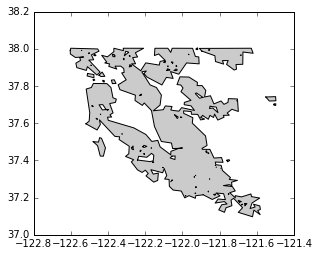

In [4]:

# Generate single geometry shape of target area
simple_ca = GeoDataFrame(geometry=GeoSeries(ca_cities_clean.buffer(0).geometry.unary_union),crs={'init': 'epsg:4269'})

# Buffer and reduce complexity of geometry - covers costal regions + improves performance
simple_ca = simple_ca.buffer(0.003).simplify(0.01, preserve_topology=True)
simple_ca.plot()


## Construct circle covering and transform to target area

In [5]:

# Function transforming initial grid into hex grid layout
def create_point(data):
    i = data[0]
    j = data[1]
    r = data[2]
    xoffset = 0
    yoffset = 0
    p = Point(i*r*math.sqrt(3) + (r*math.sqrt(3)/2 if j%2 else 0) + xoffset,
              j*r*3/4*2+yoffset)
    return shapely.affinity.scale(p.buffer(7).simplify(0.8, preserve_topology=False), xfact=r/7, yfact=r/7)


def create_circle_covering(r, width, height):
    # Accumulate initial circle grid
    circles = []
    for i in range(0, width):
        for j in range(0, height):
            circles.append([i,j,r])

    # Parallel conversion
    pool = multiprocessing.Pool(multiprocessing.cpu_count()-1)
    return pool.map(create_point, circles)


# Render the initial circle, demonstrating size and shape
%time circles = create_circle_covering(70, 50, 50)
#circles[0].area
math.pi*math.pow(70,2)/1000/1000*400


CPU times: user 148 ms, sys: 88 ms, total: 236 ms
Wall time: 292 ms


6.157521601035994

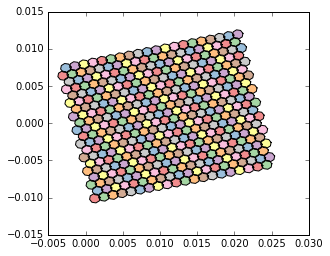

In [6]:
circles = create_circle_covering(70, 20, 20)

def transform_and_normalize_circle_covering(circles):
    # EPSG:2768 ca meters
    search_circles = GeoDataFrame(geometry=GeoSeries(circles))
    df = GeoDataFrame(geometry=GeoSeries(circles))
    df.crs = {'init': 'epsg:2768'}

    # Transfrom from meter baed EPSG:2768 coordinate system to lat/long degrees based EPSG:4269
    df = df.to_crs(ca_cities_clean.crs)

    # Translation normalization from offset due to change in coordinate systems
    df = df.translate(xoff=141.22, yoff=-30.02, zoff=0.0)
    return df

df = transform_and_normalize_circle_covering(circles)
#df.plot()

def translate_circle_covering(covering, lng, lat):
    # Translate circle covering to target location
    #%time df = df.translate(xoff=-122.2, yoff=37.4, zoff=0.0)
    df = covering.translate(xoff=lng, yoff=lat, zoff=0.0)
    return df

df = translate_circle_covering(df, 0, 0)
df.plot()

## Load existing spawn data + store in rtree for existing spawn selection

In [8]:
mons = pd.read_csv('./data/pokemon.csv', skiprows=1, usecols=[3,4,5,6], names=["num", "lat", "lng", "time"], low_memory=False)
mons.last_valid_index()

7314094

In [9]:

# Build rtree indexed dataset of existing mon spawns
idx = index.Index()

filtered_mon = mons.query('36<lat<38.1 and -123<lng<-120')
lats = filtered_mon['lat'].as_matrix()
lons = filtered_mon['lng'].as_matrix()
position_stack = np.dstack((lons,lats))

cells = []

# Populate R-tree index with bounds of grid cells
for pos, cell in enumerate(position_stack[0]):
    idx.insert(pos, (cell[0], cell[1],cell[0]+0.001, cell[1]+0.001))

filtered_mon.shape


(227413, 4)

## Filter circle query points to intersections with geometric set

CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 24.5 ms


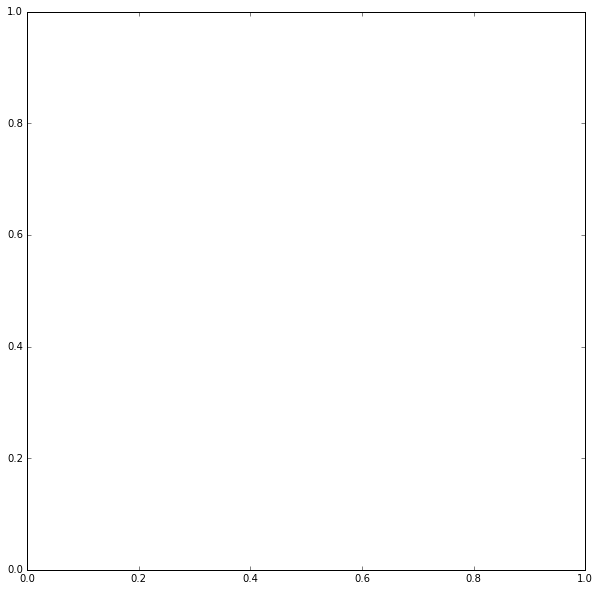

In [10]:

# Filter all circles to intersection with the target geometry
simple_ca_union = simple_ca.buffer(0).geometry.unary_union

def filter_circles_not_inside(data):
    if simple_ca_union.intersects(data):
        return data
    else:
        return False

final_circles = []
pool = multiprocessing.Pool(multiprocessing.cpu_count()-1)
%time final_circles = filter(lambda x: x != False, pool.map(filter_circles_not_inside, df.geometry))

search_circles = GeoDataFrame(geometry=GeoSeries(final_circles))
search_circles.plot(figsize=(10,10))

In [ ]:
search_circles.plot(ax=ca_cities_clean.plot(figsize=(10,10)), figsize=(10,10))

## Coverage based solely on existing spawn points

In [ ]:

# Filter all circles to intersection with the target geometry

def filter_circles_not_inside(data):
    if len(list(idx.intersection(data.bounds))):
        return data
    else:
        return False

final_circles = []
pool = multiprocessing.Pool(multiprocessing.cpu_count()-1)
%time final_circles = filter(lambda x: x != False, pool.map(filter_circles_not_inside, df.geometry))

search_circles = GeoDataFrame(geometry=GeoSeries(final_circles))
search_circles.plot(ax=ca_cities_clean.plot(figsize=(10,10)), figsize=(10,10))

## Chunked rect covering for worker allocation

(386, 1)

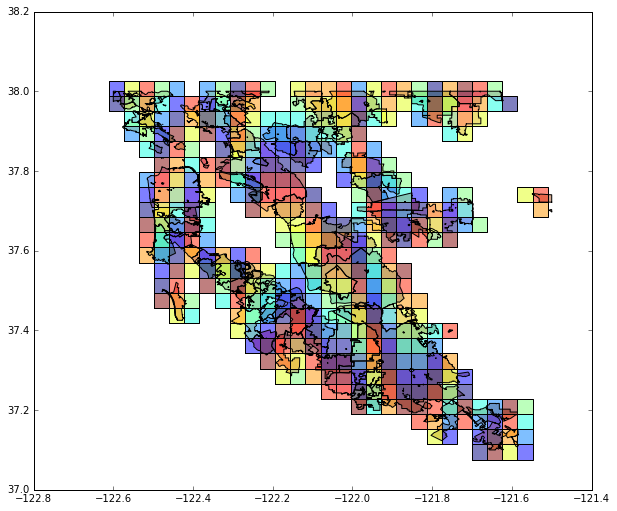

In [7]:
def chunked_rect_covering(rect_start_lng, rect_start_lat, rect_width, grid_width, grid_height):
    rects = []
    for i in range(0,grid_width):
        rect_lng = rect_start_lng + rect_width * i
        for j in range(0,grid_height):
            rect_lat = rect_start_lat + rect_width * j
            rects.append(Polygon([(rect_lng, rect_lat), 
                                  (rect_lng+rect_width,rect_lat), 
                                  (rect_lng+rect_width,rect_lat+rect_width), 
                                  (rect_lng,rect_lat+rect_width)]))

    search_rects = GeoDataFrame(geometry=GeoSeries(rects))

    simple_ca_union = simple_ca.buffer(0).geometry.unary_union

    def filter_rects_not_inside(data):
        if simple_ca_union.intersects(data):
            return data
        else:
            return False

    final_rects = []
    pool = multiprocessing.Pool(multiprocessing.cpu_count()-1)
    final_rects = filter(lambda x: x != False, pool.map(filter_rects_not_inside, search_rects.geometry))

        
    return GeoDataFrame(geometry=GeoSeries(final_rects))

search_rects = chunked_rect_covering(-122.65, 37.0, 0.038, 30, 30)
search_rects.plot(ax=ca_cities_clean.plot(figsize=(10,10)), figsize=(10,10))
search_rects.shape

In [8]:

# Transfrom from meter baed EPSG:2768 coordinate system to lat/long degrees based EPSG:4269
search_rects.crs = {'init': 'epsg:4269'}
area_search_rects = search_rects.to_crs({'init': 'epsg:2768'})
total = 0
for r in area_search_rects.geometry:
    print r.area /1000/1000
    total = total +  r.area /1000/1000
print total

14.0817490773
14.0746559648
14.095953383
14.0888482135
14.0817490773
14.0746559648
14.1530130751
14.1458592975
14.1387116293
14.1315700609
14.1244345829
14.1173051856
14.1030645951
14.095953383
14.0888482135
14.0817490773
14.0746559648
14.17451116
14.1673389968
14.1601729717
14.1530130751
14.1458592975
14.1387116293
14.1315700609
14.1244345829
14.1173051856
14.1101818595
14.1030645951
14.095953383
14.0888482135
14.0817490773
14.0746559648
14.181689471
14.17451116
14.1673389968
14.1601729717
14.1530130751
14.1458592975
14.1387116293
14.1315700609
14.1244345829
14.1173051856
14.1101818595
14.1030645951
14.095953383
14.0888482135
14.0817490773
14.0746559648
14.181689471
14.17451116
14.1601729717
14.1530130751
14.1458592975
14.1387116293
14.1315700609
14.1244345829
14.1173051856
14.1101818595
14.1030645951
14.095953383
14.0888482135
14.0817490773
14.1673389968
14.1601729717
14.1530130751
14.1458592975
14.1387116293
14.1315700609
14.1244345829
14.1173051856
14.1101818595
14.095953383
14.088

In [9]:
circle_covering = create_circle_covering(70, 50, 65)
norm_covering = transform_and_normalize_circle_covering(circle_covering)
#df = translate_circle_covering(df, -122.6, 37)
total_queries = 0
for i, r in enumerate(search_rects.geometry):
    print "GETTING TILE {}".format(i)
    bounded_rect = ca_cities_clean.intersection(r)
    bounded_rect_union = bounded_rect.geometry.unary_union
    b = bounded_rect_union.bounds
    try:
        trans_covering = translate_circle_covering(norm_covering, b[0], b[1])

        def filter_circles_not_inside(data):
            if bounded_rect_union.intersects(data):
                return data
            else:
                return False

        final_circles = []
        pool = multiprocessing.Pool(multiprocessing.cpu_count()-1)
        %time final_circles = filter(lambda x: x != False, pool.map(filter_circles_not_inside, trans_covering.geometry))
        pool.terminate()
        search_circles = GeoDataFrame(geometry=GeoSeries(final_circles))
        #search_circles.plot(ax=bounded_rect.plot(figsize=(10,10)), figsize=(10,10))
        #trans_covering.plot(ax=bounded_rect.plot(figsize=(10,10)), figsize=(10,10))
        total_queries = total_queries + search_circles.shape[0]
    except:
        print "probably no bounds"

total_queries
    
    

GETTING TILE 0
CPU times: user 164 ms, sys: 24 ms, total: 188 ms
Wall time: 173 ms
GETTING TILE 1
CPU times: user 204 ms, sys: 44 ms, total: 248 ms
Wall time: 225 ms
GETTING TILE 2
CPU times: user 204 ms, sys: 36 ms, total: 240 ms
Wall time: 209 ms
GETTING TILE 3
CPU times: user 196 ms, sys: 60 ms, total: 256 ms
Wall time: 217 ms
GETTING TILE 4
CPU times: user 252 ms, sys: 64 ms, total: 316 ms
Wall time: 257 ms
GETTING TILE 5
CPU times: user 180 ms, sys: 32 ms, total: 212 ms
Wall time: 177 ms
GETTING TILE 6
CPU times: user 204 ms, sys: 28 ms, total: 232 ms
Wall time: 220 ms
GETTING TILE 7
CPU times: user 116 ms, sys: 12 ms, total: 128 ms
Wall time: 122 ms
GETTING TILE 8
probably no bounds
GETTING TILE 9
CPU times: user 180 ms, sys: 32 ms, total: 212 ms
Wall time: 201 ms
GETTING TILE 10
CPU times: user 228 ms, sys: 20 ms, total: 248 ms
Wall time: 229 ms
GETTING TILE 11
CPU times: user 220 ms, sys: 20 ms, total: 240 ms
Wall time: 216 ms
GETTING TILE 12
CPU times: user 184 ms, sys: 28 ms,

282981

CPU times: user 281 ms, sys: 59.3 ms, total: 340 ms
Wall time: 1.74 s


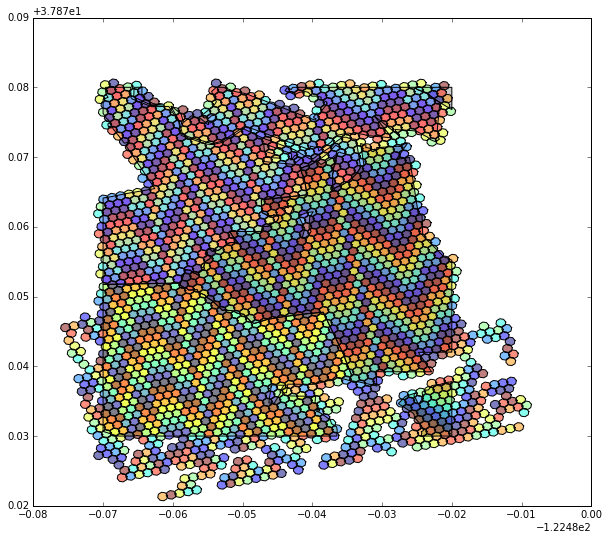

In [11]:
circle_covering = create_circle_covering(70, 50, 65)
norm_covering = transform_and_normalize_circle_covering(circle_covering)
#df = translate_circle_covering(df, -122.6, 37)

for r in search_rects.geometry[10:11]:
    bounded_rect = ca_cities_clean.intersection(r)
    bounded_rect_union = bounded_rect.geometry.unary_union
    b = bounded_rect_union.bounds
    trans_covering = translate_circle_covering(norm_covering, b[0], b[1])
    
    def filter_circles_not_inside(data):
        if len(list(idx.intersection(data.bounds))) or bounded_rect_union.intersects(data):
            return data
        else:
            return False
        
    final_circles = []
    pool = multiprocessing.Pool(multiprocessing.cpu_count()-1)
    %time final_circles = filter(lambda x: x != False, pool.map(filter_circles_not_inside, trans_covering.geometry))
    pool.terminate()
    search_circles = GeoDataFrame(geometry=GeoSeries(final_circles))
    search_circles.plot(ax=bounded_rect.plot(figsize=(10,10)), figsize=(10,10))
    #trans_covering.plot(ax=bounded_rect.plot(figsize=(10,10)), figsize=(10,10))

    
    